## Nnet-survival PDAC Transfer learning

Imports

In [150]:
import os
import keras.optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.keras.backend as K
import keras_tuner
import nnet_survival
import keras_tuner as kt
import tensorflow as tf
import importlib
import lasagne
import nnet_survival
import cox_nnet_v2 as cox_nnet

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from matplotlib.pyplot import figure
from tensorflow import keras
from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import load_model
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored,brier_score
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sksurv.util import Surv
from keras_tuner import HyperModel
from tensorflow.keras.metrics import Metric

### Import multi-cancer Data
<p> For every file in folder open read inside and store in pandas dataframe </p>

In [152]:
# Create a new list mrna_list which contains pandas dataframes of each cancer datasets rna expression data
# Create a new list clinical_list which contains clinical data for each cancer dataset

mrna_list = []
mrna_folder = "Data/mrnaDataUnscaled"
clinical_folder = "Data/ClinicalData"
for filename in sorted(os.listdir(mrna_folder)):
    f = os.path.join(mrna_folder, filename)
    print(f)
    data = pd.read_csv(f, sep=",")
    mrna_list.append(data)
    
clinical_list = []
for filename in sorted(os.listdir(clinical_folder)):
    f = os.path.join(clinical_folder, filename)
    data = pd.read_csv(f, sep="\t")
    clinical_list.append(data)

Data/mrnaDataUnscaled/ACC.csv
Data/mrnaDataUnscaled/BLCA.csv
Data/mrnaDataUnscaled/BRCA.csv
Data/mrnaDataUnscaled/CESC.csv
Data/mrnaDataUnscaled/CHOL.csv
Data/mrnaDataUnscaled/COAD.csv
Data/mrnaDataUnscaled/DLBC.csv
Data/mrnaDataUnscaled/ESCA.csv
Data/mrnaDataUnscaled/GBM.csv
Data/mrnaDataUnscaled/HNSC.csv
Data/mrnaDataUnscaled/KICH.csv
Data/mrnaDataUnscaled/KIRC.csv
Data/mrnaDataUnscaled/KIRP.csv
Data/mrnaDataUnscaled/LAML.csv
Data/mrnaDataUnscaled/LGG.csv
Data/mrnaDataUnscaled/LIHC.csv
Data/mrnaDataUnscaled/LUAD.csv
Data/mrnaDataUnscaled/LUSC.csv
Data/mrnaDataUnscaled/MESO.csv
Data/mrnaDataUnscaled/OV.csv
Data/mrnaDataUnscaled/PCPG.csv
Data/mrnaDataUnscaled/PRAD.csv
Data/mrnaDataUnscaled/READ.csv
Data/mrnaDataUnscaled/SARC.csv
Data/mrnaDataUnscaled/SKCM.csv
Data/mrnaDataUnscaled/STAD.csv
Data/mrnaDataUnscaled/TGCT.csv
Data/mrnaDataUnscaled/THCA.csv
Data/mrnaDataUnscaled/THYM.csv
Data/mrnaDataUnscaled/UCEC.csv
Data/mrnaDataUnscaled/UCS.csv
Data/mrnaDataUnscaled/UVM.csv


### Prepare multi-cancer data for tensorflow 
<p>Every data set is handled individually, and merged in the end.<br></p>

<ol>
  <li>First The clinical samples are matched to the genomic samples.</li>
  <li>Then samples are filtered out of the clinical data that are not in the mRNA data</li>
  <li>After that all Not availables and Discrepancys are replaced with NaN.</li>
  <li>Vital status Dead and Alive are set to 1 and 0 respectively.</li>
  <li>Days are made numerical.</li>
  <li>Remove patients that have time 0 or NaN for time/status.</li>
  <li>Set Index of mRNA and clinical to patient barcode, and transpose the mRNA data so that the patients are in each row, and the genes in each column.</li>
</ol>

In [72]:
x_list = []
clinical_processed_list = []

for mrna,clinical in zip(mrna_list,clinical_list):
    mrna_id = mrna.columns[1:]

    # Match clinical samples to genomic samples
    clinical.columns = clinical.iloc[0]
    clinical = clinical.iloc[2:]

    # Make intersection of patient id's that are in mrna and clinicaldata
    clinical_id = clinical['bcr_patient_barcode']
    intersection = list(set(mrna_id) & set(clinical_id))
    intersection.sort()
    intersection = pd.Series(intersection)


    # Filter out samples in clinicaldata that are not in mrna
    a = clinical['bcr_patient_barcode'].isin(intersection)
    clinical = clinical[a]



    # Create clinicaldata dataframe with the important features
    clinicalnew = clinical[['bcr_patient_barcode',
                                "vital_status",
                                "days_to_last_followup",
                                "days_to_death"]]
    
    #print(clinicalnew['vital_status'].value_counts())
    

    # Set missing data to NaN
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Discrepancy]", 0)
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Not Available]",np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Applicable]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Available]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Not Available]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Completed]", np.nan)

    # In vital_status set dead = 1 alive = 0
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("Dead", 1)
    clinicalnew["vital_status"] = clinicalnew['vital_status'].replace("Alive", 0)

    # Set days to numeric values
    clinicalnew["days_to_last_followup"] = pd.to_numeric(clinicalnew["days_to_last_followup"])
    clinicalnew["days_to_death"] = pd.to_numeric(clinicalnew["days_to_death"])

    # Combine days to death and days to last follow up to create a total time.
    clinicalnew['time'] = clinicalnew['days_to_death'].combine_first(clinicalnew['days_to_last_followup'])

    # Remove patients that have time 0 (so no follow up, just one recording)
    clinicalnew = clinicalnew[clinicalnew.time != 0]

    #Remove patients with nan for time or status
    clinicalnew = clinicalnew.dropna(subset=['time'])
    clinicalnew = clinicalnew.dropna(subset=['vital_status'])
    
    #Remove patients where time is negative
    clinicalnew = clinicalnew[clinicalnew.time >= 0]

    mrna.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'}, inplace=True)
    mrna = mrna.set_index('bcr_patient_barcode')

    mrna = mrna.transpose()
    mrna = mrna[mrna.index.isin(clinicalnew['bcr_patient_barcode'])]
    mrna = mrna.reindex(np.random.RandomState(seed=1).permutation(mrna.index))
    
    clinicalnew = clinicalnew.set_index('bcr_patient_barcode')
    clinicalnew = clinicalnew.loc[~clinicalnew.index.duplicated(), :]
    clinicalnew = clinicalnew.reindex(index=mrna.index)
    
    x_list.append(mrna)
    clinical_processed_list.append(clinicalnew)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [30]:
# Concatenate the list of processed RNA-seq pandas dataframes together to one large dataset
# Drop the NA values
# Concatenate the list of processed Clinical pandas dataframes together to one large dataset

xf_full = pd.concat(x_list)
xf_full = xf_full.dropna(axis=1)
clinicalf_full = pd.concat(clinical_processed_list)

### Import subset of cancers

<p> These cancers are most similar to PDAC, and give a small increase in performance</p>
<p> Same procedure as above </p>
<ul>
    <li>LUAD</li>
  <li>STAD</li>
  <li>CHOL</li>
  <li>SARC</li>
  <li>TGCT</li>
    <li>COAD</li>
</ul>

In [31]:
# Create a new list mrna_list which contains pandas dataframes of each cancer datasets rna expression data for the subset of cancers
# Create a new list clinical_list which contains clinical data for each cancer dataset

mrna_list = []
mrna_folder = "Data/subsetMrna"
clinical_folder = "Data/subsetClinical"
for filename in sorted(os.listdir(mrna_folder)):
    f = os.path.join(mrna_folder, filename)
    print(f)
    data = pd.read_csv(f, sep=",")
    mrna_list.append(data)
    
clinical_list = []
for filename in sorted(os.listdir(clinical_folder)):
    f = os.path.join(clinical_folder, filename)
    data = pd.read_csv(f, sep="\t")
    clinical_list.append(data)

Data/subsetMrna/CHOL.csv
Data/subsetMrna/COAD.csv
Data/subsetMrna/LUAD.csv
Data/subsetMrna/SARC.csv
Data/subsetMrna/STAD.csv
Data/subsetMrna/TGCT.csv


### Prepare subset of cancer data for tensorflow 

<p> Same steps as described above </p>

In [32]:
x_list = []
clinical_processed_list = []

for mrna,clinical in zip(mrna_list,clinical_list):
    mrna_id = mrna.columns[1:]

    # Match clinical samples to genomic samples
    clinical.columns = clinical.iloc[0]
    clinical = clinical.iloc[2:]

    # Make intersection of patient id's that are in mrna and clinicaldata
    clinical_id = clinical['bcr_patient_barcode']
    intersection = list(set(mrna_id) & set(clinical_id))
    intersection.sort()
    intersection = pd.Series(intersection)


    # Filter out samples in clinicaldata that are not in mrna
    a = clinical['bcr_patient_barcode'].isin(intersection)
    clinical = clinical[a]



    # Create clinicaldata dataframe with the important features
    clinicalnew = clinical[['bcr_patient_barcode',
                                "vital_status",
                                "days_to_last_followup",
                                "days_to_death"]]
    
    #print(clinicalnew['vital_status'].value_counts())
    

    # Set missing data to NaN
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Discrepancy]", 0)
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Not Available]",np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Applicable]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Available]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Not Available]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Completed]", np.nan)

    # In vital_status set dead = 1 alive = 0
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("Dead", 1)
    clinicalnew["vital_status"] = clinicalnew['vital_status'].replace("Alive", 0)

    # Set days to numeric values
    clinicalnew["days_to_last_followup"] = pd.to_numeric(clinicalnew["days_to_last_followup"])
    clinicalnew["days_to_death"] = pd.to_numeric(clinicalnew["days_to_death"])

    # Combine days to death and days to last follow up to create a total time.
    clinicalnew['time'] = clinicalnew['days_to_death'].combine_first(clinicalnew['days_to_last_followup'])

    # Remove patients that have time 0 (so no follow up, just one recording)
    clinicalnew = clinicalnew[clinicalnew.time != 0]

    #Remove patients with nan for time or status
    clinicalnew = clinicalnew.dropna(subset=['time'])
    clinicalnew = clinicalnew.dropna(subset=['vital_status'])
    
    #Remove patients where time is negative
    clinicalnew = clinicalnew[clinicalnew.time >= 0]

    mrna.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'}, inplace=True)
    mrna = mrna.set_index('bcr_patient_barcode')

    mrna = mrna.transpose()
    mrna = mrna[mrna.index.isin(clinicalnew['bcr_patient_barcode'])]
    mrna = mrna.reindex(np.random.RandomState(seed=1).permutation(mrna.index))
    
    clinicalnew = clinicalnew.set_index('bcr_patient_barcode')
    clinicalnew = clinicalnew.loc[~clinicalnew.index.duplicated(), :]
    clinicalnew = clinicalnew.reindex(index=mrna.index)
    
    x_list.append(mrna)
    clinical_processed_list.append(clinicalnew)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [33]:
# Concatenate the list of processed RNA-seq pandas dataframes together to one large dataset
# Drop the NA values
# Concatenate the list of processed Clinical pandas dataframes together to one large dataset

xf_sub = pd.concat(x_list)
xf_sub = xf_sub.dropna(axis=1)
clinicalf_sub = pd.concat(clinical_processed_list)

### TCGA PDAC data preparation

<p> Same steps as above </p>

In [148]:
# Load TCGA PDAC clinical and RNA-seq data

clinicaldata = pd.read_csv(f"Data/TargetDataUnscaled/nationwidechildrens.org_clinical_patient_paad.txt", sep='\t')
mrna = pd.read_csv(f"Data/TargetDataUnscaled/PAAD.csv", sep=',')

In [149]:
mrna_id = mrna.columns[1:].tolist()

# Match clinical samples to genomic samples
clinicaldata.columns = clinicaldata.iloc[0]
clinicaldata = clinicaldata.iloc[2:]


# Make intersection of patient id's that are in mrna and clinicaldata
clinical_id = clinicaldata['bcr_patient_barcode']
intersection = list(set(mrna_id) & set(clinical_id))
intersection.sort()
intersection = pd.Series(intersection)


# Filter out samples in clinicaldata that are not in mrna
a = clinicaldata['bcr_patient_barcode'].isin(intersection)
clinicaldata = clinicaldata[a]


clinicalnew = clinicaldata


# Create clinicaldata dataframe with the important features
# clinicalnew = clinicaldata[['bcr_patient_barcode',
#                             "vital_status",
#                             "days_to_last_followup",
#                             "days_to_death"]]



# Set missing data to NaN
clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Discrepancy]", 0)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Applicable]", np.nan)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Available]", np.nan)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Discrepancy]", np.nan)
clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Not Available]", np.nan)
clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)

# In vital_status set dead = 1 alive = 0
clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("Dead", 1)
clinicalnew["vital_status"] = clinicalnew['vital_status'].replace("Alive", 0)

# Set days to numeric values
clinicalnew["days_to_last_followup"] = pd.to_numeric(clinicalnew["days_to_last_followup"])
clinicalnew["days_to_death"] = pd.to_numeric(clinicalnew["days_to_death"])

# Combine days to death and days to last follow up to create a total time.
clinicalnew['time'] = clinicalnew['days_to_death'].combine_first(clinicalnew['days_to_last_followup'])

# Remove patients that have time 0 (so no follow up, just one recording)
clinicalnew = clinicalnew[clinicalnew.time != 0]

#Remove patients with nan for time
clinicalnew = clinicalnew.dropna(subset=['time'])

mrna.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'}, inplace=True)
mrna = mrna.set_index('bcr_patient_barcode')

mrna = mrna.transpose()
mrna = mrna[mrna.index.isin(clinicalnew['bcr_patient_barcode'])]
mrna = mrna.reindex(np.random.RandomState(seed=1).permutation(mrna.index))
clinicalnew = clinicalnew.set_index('bcr_patient_barcode')
clinicalnew = clinicalnew.reindex(index=mrna.index)

In [65]:
xt = mrna
yt = clinicalnew

### TCGA ICGC Data
<p> Similar steps to above </p>

In [37]:
# Load ICGC clinical and mrna data

clinicaldata = pd.read_csv(f"Data/ICGCDataUnscaled/PDAC_ICGC_clinical.csv", sep=',')
mrna = pd.read_csv(f"Data/ICGCDataUnscaled/PDAC_ICGC.csv", sep=',')

In [38]:
# Create clinicaldata dataframe with the important features
clinicalnew = clinicaldata[['icgc_donor_id',
                            "donor_vital_status",
                            "donor_survival_time"]]



# Set missing data to NaN
clinicalnew['donor_vital_status'] = clinicalnew['donor_vital_status'].replace("", np.nan)

# In vital_status set dead = 1 alive = 0
clinicalnew['donor_vital_status'] = clinicalnew['donor_vital_status'].replace("deceased", 1)
clinicalnew["donor_vital_status"] = clinicalnew['donor_vital_status'].replace("alive", 0)

# Set days to numeric values
clinicalnew["donor_survival_time"] = pd.to_numeric(clinicalnew["donor_survival_time"])

# Combine days to death and days to last follow up to create a total time.
clinicalnew['time'] = clinicalnew['donor_survival_time']

# Remove patients that have time 0 (so no follow up, just one recording)
clinicalnew = clinicalnew[clinicalnew.time != 0]

#Remove patients with nan for time
clinicalnew = clinicalnew.dropna(subset=['time'])

mrna.rename(columns={'Unnamed: 0': 'icgc_donor_id'}, inplace=True)
mrna = mrna.set_index('icgc_donor_id')

clinicalnew = clinicalnew.set_index('icgc_donor_id')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [39]:
xv = mrna
yv = clinicalnew

In [40]:
xv = xv.drop(['DO49201'])

### Match the genes in all 3 datasets to each other
<p> We now have 3 datasets: A large multi-cancer dataset, a PDAC dataset, and a ICGC PDAC dataset. </p>
<p>Here we make sure all datasets contain the same genes, and the order of the genes is the same </p>

In [41]:
# Split the column names into transcript id's and genes again to make similar to ICGC data later on

columns = xt.columns.str.split(' / ')
correct_columns = []
for column in columns:
    correct_columns.append(column[0])

xt.columns = correct_columns

In [42]:
# Split the column names into transcript id's and genes again to make similar to ICGC data later on

columns = xf_full.columns.str.split(' / ')
correct_columns = []
for column in columns:
    correct_columns.append(column[0])

xf_full.columns = correct_columns

In [43]:
# Split the column names into transcript id's and genes again to make similar to ICGC data later on

columns = xf_sub.columns.str.split(' / ')
correct_columns = []
for column in columns:
    correct_columns.append(column[0])

xf_sub.columns = correct_columns

In [45]:
# Drop the genes in the TCGA PDAC data that are not in the full 32 cancer dataset

labels_to_drop = xt.columns.difference(xf_full.columns)
xt = xt.drop(labels=labels_to_drop,axis=1)

In [46]:
# Remove all duplicated genes in the three dataset

xt = xt.loc[:,~xt.columns.duplicated()].copy()
xf_full = xf_full.loc[:,~xf_full.columns.duplicated()].copy()
xf_sub = xf_sub.loc[:,~xf_sub.columns.duplicated()].copy()

In [47]:
# Drop genes from datasets so that they are all similar in number

xt = xt.drop(labels=(xt.columns.difference(xf_full.columns)),axis=1)
xv = xv.drop(labels=(xv.columns.difference(xf_full.columns)),axis=1)
xf_full = xf_full.drop(labels=(xf_full.columns.difference(xt.columns)),axis=1)
xf_sub = xf_sub.drop(labels=(xf_sub.columns.difference(xt.columns)),axis=1)

In [48]:
# Drop genes from TCGA data so they are similar to ICGC data

xt = xt.drop(labels=(xt.columns.difference(xv.columns)),axis=1)
xf_full = xf_full.drop(labels=(xf_full.columns.difference(xv.columns)),axis=1)
xf_sub = xf_sub.drop(labels=(xf_sub.columns.difference(xv.columns)),axis=1)

Check if number of features/genes is the same

In [79]:
print(xt.shape)
print(xf_full.shape)
print(xf_sub.shape)
print(xv.shape)

(143, 12668)
(8685, 12668)
(1529, 12668)
(72, 12668)
(8828, 12668)


In [50]:
# Set the order of the genes to how to they occur in the TCGA PDAC data

xv = xv[xt.columns]
xf_full = xf_full[xt.columns]
xf_sub = xf_sub[xt.columns]


### Source model
<p> Start with setting pandas dataframes to numpy arrays </p>
<p> Choose the first code block underneath to use the 32 cancer dataset as the source dataset </p>
<p> Choose the second code block underneath to use the subset of cancers similar to PDAC </p>
    

In [81]:
# Set pandas dataframes to numpy arrays, also create numpy arrays from the time and vital status data
# The large 32 cancer dataset is used here

xf = xf_full_paad.to_numpy()
yf = clinicalf_full_paad

ytime = yf['time'].to_numpy()
ystatus = yf['vital_status'].to_numpy()
ystatusbool = yf['vital_status'].astype(np.bool)



In [81]:
# Set pandas dataframes to numpy arrays, also create numpy arrays from the time and vital status data
# The subset of cancers similar to PDAC dataset is used here

xf = xf_sub.to_numpy()
yf = clinicalf_sub

ytime = yf['time'].to_numpy()
ystatus = yf['vital_status'].to_numpy()
ystatusbool = yf['vital_status'].astype(np.bool)



<p> Here we set our quantiles and make new labels that assign a quantile to each patient. </p>

In [82]:
# Create time quantiles to later be used in stratification

first_quantile = np.quantile(ytime,0.25)
second_quantile = np.quantile(ytime,0.5)
third_quantile = np.quantile(ytime,0.75)


In [84]:
# For every patient's time value in ytime check in what quantile it falls and make a new list that contains the corresponding time quantile for each patient

yquantile = []
for time in ytime:
    if time >= 0 and time < first_quantile:
        yquantile.append(1)
    elif time >= first_quantile and time < second_quantile:
        yquantile.append(2)
    elif time >= second_quantile and time < third_quantile:
        yquantile.append(3)
    elif time >= third_quantile:
        yquantile.append(4)


### Set time interval for nnet survival custom loss function

><p>The time intervals should be set so that for every interval an equal amount of events occur. This is done with matplotlib and manually adjusting the bins untill you see an equal number of events per interval</p>

In [ ]:
# Check how many death events are in the data so you know how many death events you need per time interval

number_of_events = (yf.vital_status == 1).sum()
number_of_nonevents = (yf.vital_status == 0).sum()

print(number_of_events)
print(number_of_nonevents)

(array([17., 17., 16., 17., 16., 17., 15., 15., 17., 16., 17., 17., 16.,
        16., 16., 17., 18., 18., 17., 17.]),
 array([   0,   40,   98,  153,  180,  240,  280,  330,  370,  428,  495,
         580,  660,  750,  860,  990, 1170, 1400, 1660, 2100, 7000]),
 <BarContainer object of 20 artists>)

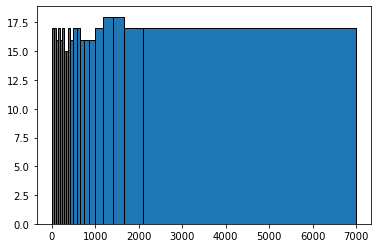

In [157]:
# Create a plot where you set the time interval bins in the bins variable, the plot should be as straight as possible, containing an equal number of death events per time interval

test = yf.loc[yf['vital_status'] == 1]

plt.hist(test['time'], bins=[0,55,100,135,180,240,260,322,370,430,455,520,580,620,730,840,970,1140,1350,1590,1900,2540,9200],ec='black')

><p> Here we set our time intervals and create the survival matrix used by the nnet-survival model </p>

In [87]:
# Here we set the breaks for our time intervals which we obtained with the plot above
# Use the first breaks for the large 32 cancer dataset, use the second breaks for the subset of cancers

breaks=np.asarray([0,55,100,135,180,240,260,322,370,430,455,520,580,620,730,840,970,1140,1350,1590,1900,2540,9200])
# breaks=np.asarray([0,40,98,153,180,240,280,330,370,428,495,580,660,750,860,990,1170,1400,1660,2100,7000])
n_intervals = len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

In [89]:
# Create the survival array using the nnet_survival fuction 'make_surv_array'
# This function takes the following input:
#    ytime - numpy array of each patient's time until death/censor value
#    ystatus - numpy array of each patient's survival status (1 for death event, 0 for alive/censored)
#    breaks - the breaks for the time intervals that were 

yf = nnet_survival.make_surv_array(ytime, ystatus, breaks)


<p> This step adds the status and quantile labels to our survival matrix <br>
This is used only with our 5-fold CV hyperparameter optimization</p>

In [90]:
# For every survival matrix, status value, and quantile value merge the status and quantile values together and merge with the survival matrix.

yf_final = ([],[])

for matrix,status,quantile in zip(yf,ystatus,yquantile):
    yf_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yf_final[1].append(status_quantile)




## Custom class for hypermodel + concordance index function
<p> This code block shows 2 custom classes, one being a hypermodel that is built by our hyperparameter tuner, and where you can add variable parameters which will be tested. <br>
The other is a custom hyper parameter tuner that utilizes cross validation.</p>

In [87]:
class SurvivalHyperModel(HyperModel):
    def __init__(self, n_intervals, weights=[]):
        self.n_intervals = n_intervals
        self.weights = weights
    def build(self, hp):
        model = Sequential()
        hp_l2_value = hp.Choice('l2_value', values=[0.01,0.001,0.0001,0.00001])
        model.add(Dense(np.sqrt(xf.shape[1]), input_dim=xf.shape[1], bias_initializer='zeros',activation='relu', kernel_regularizer=regularizers.l2(hp_l2_value)))
        model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
        model.add(nnet_survival.PropHazards(self.n_intervals))
        model.compile(loss=nnet_survival.surv_likelihood(self.n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001),run_eagerly=False)
        if self.weights:
            model.layers[0].set_weights(self.weights)
            return model
        else:
            return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         shuffle=False,
                         **kwargs,
                        )
    
class CVTuner(keras_tuner.engine.tuner.Tuner):
    def run_trial(self, trial, x, y,epochs=1, *args, **kwargs):
        skf = StratifiedKFold(n_splits=5, shuffle=False)
        skf.get_n_splits(x,y[1])
        val_losses = []
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[8,16,32])
        fold = 1
        hp = trial.hyperparameters
        for train_indices, test_indices in skf.split(x,y[1]):
            early_stopping_hp = EarlyStopping(monitor='val_loss', patience=(100),min_delta=0.0005, restore_best_weights=True)
            dir_for_logs = ("Logs/ktuner/logs_pdac_21/" + str(trial.trial_id) + "/fold_" + str(fold))
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_for_logs, histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
            callbacks_list = [early_stopping_hp,tensorboard_callback]
            x_train, x_test = x[train_indices], x[test_indices]
            y_train, y_test = np.array(y[0])[train_indices], np.array(y[0])[test_indices]
            y_train_labels, y_test_labels = np.array(y[1])[train_indices], np.array(y[1])[test_indices]
            model = self.hypermodel.build(hp)
            model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=kwargs['batch_size'], epochs=epochs, callbacks=callbacks_list, verbose=0)       
            y_pred = model.predict(x_test, verbose=0)
            surv_prob=np.cumprod(y_pred, axis=1)[:,-1]
            val_losses.append(model.evaluate(x_test, y_test))
            fold += 1
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

    

### Hyperparameter optimization and training of the multi-cancer model

<p> In this section of code the hyperparameter tuning of the multi-cancer model occurs. <br>
    The Hyperparameters are tuned on the whole datasets, and the results can be viewed with tensorboard. </p>

In [ ]:
importlib.reload(nnet_survival)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Scale the input features using MinMaxScaler

scaler = MinMaxScaler()
xf_t = scaler.fit_transform(xf)

# logfile - Filename in which the results will be stored of the hyperparameter tuning.
#           Call this file with Tensorboard to view loss curves and hyperparameter tuning results.
#
# name_of_project - Name of the Keras Tuner project.
#                   Make sure this is different if you want to try a new search, else it will 
#                   just give you the results of the project previous project that had the same name !!!!
#
# name_of_dir - Directory where projects will be stored.

logfile = "Logs/ktuner/logs_pretrain_9_5/"
name_of_project = "pretrain_model_9_5"
name_of_dir = "pretrain_model_dir"

# The Cross validation tuner class, takes as input:
#    hypermodel - A hypermodel class, which is your model but contains hyperparameter values for every parameter you want to test
#    directory - Directory where the hyper parameter tuning project will be stored
#    logger - Takes a TensorBoardLogger value as input which will store the loss of the model during training steps, 
#             which can be used in TensorBoard to create plots
#    oracle - The keras tuner optimization method that you want to use, refer to: https://keras.io/api/keras_tuner/oracles/ for possible oracles.
#             takes as input:
#             objective - The objective of the hyperparameter tuning, and what determines whether a set of parameters is 'good'
#             max_trials - The number of trials you wish to perform, each trial will contain a set of parameters to test.
#
# After creating the class, use .search to initiate the hyperparameter tuning, takes as input:
#    xf_t - the scaled input features to train on
#    yf_final - the label on which predictions will be assessed, contains the survival matrix and status_quantile for a patient
#    epochs - the maximum number of epochs you wish to train (Early stopping is included in the class, so value is determined automatically)
#    verbose - 1 to see progress of hyperparameter tuning in console, 0 to not see progress.
                                                
tuner = CVTuner(
    hypermodel=SurvivalHyperModel(n_intervals),
    project_name=name_of_project,
    directory=name_of_dir,
    logger = TensorBoardLogger(metrics=["val_loss"], logdir=logfile),
    oracle=kt.oracles.BayesianOptimization(
        objective='val_loss',
        max_trials=10))
tuner.search(xf_t,yf_final,epochs=40000,verbose=1)




<p> Now the source model is ran using the optimal parameters found in the previous step </p>

In [91]:
importlib.reload(nnet_survival)

# Set the optimal parameters found for the source model

optimal_l2 = 0.01
optimal_batch = 16

# Scale the input features using MinMaxScaler

scaler = MinMaxScaler()
xf_t = scaler.fit_transform(xf)

# Set the labels to the survival matrices

yf = np.array(yf_final[0])

# Create the model with the optimal parameters

optimal_model = Sequential()
optimal_model.add(Dense(np.sqrt(xf.shape[1]), input_dim=xf.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
optimal_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
optimal_model.add(nnet_survival.PropHazards(n_intervals))
opt = optimizers.Adam(learning_rate=0.00001)
optimal_model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=opt)


# Create a tensorboard callback which saves the loss during the training of the model

dir_for_log = ("Logs/ktuner/source_model_full_paad")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_for_log, histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

# Fit the model to the input data xf_t and yf

history = optimal_model.fit(xf_t,yf,batch_size=optimal_batch,epochs=1200, callbacks=callbacks_list,verbose=0)

# Save the weights of the source model

optimal_model.save_weights("Weights/source_model_full_paad")   

# Get performance of source model on full dataset which is very optimistic

print("Performance model on full dataset (very optimistic):")
y_pred = optimal_model.predict(xf_t, verbose=0)
oneyr_surv = np.cumprod(y_pred[:, 0:np.nonzero(breaks > 365)[0][0]], axis=1)[:, -1]
c_index_test = concordance_index(ytime, oneyr_surv, ystatus)
print("C_index: " + str(c_index_test))

2023-02-02 10:00:50.520361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 10:00:50.626508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 10:00:50.627256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 10:00:50.630545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

C_index: 0.9296680882252264



### Data preperation TCGA PDAC

In [101]:
# Set pandas dataframes of TCGA RNA-seq data to numpy array
# Set pandas dataframes of TCGA clinical data (time and vital_status) to numpy arrays

xt = xt.to_numpy()
#
ytime = yt['time'].to_numpy()
ystatus = yt['vital_status'].to_numpy()
ystatusbool = yt['vital_status'].astype(np.bool).to_numpy()


(array([15., 14., 15., 15., 14., 13., 14., 14., 14., 15.]),
 array([   0,   17,   70,  130,  180,  230,  300,  400,  580,  730, 2200]),
 <BarContainer object of 10 artists>)

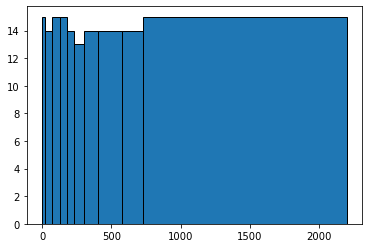

In [102]:
# Create a plot where you set the time interval bins in the bins variable, the plot should be as straight as possible, containing an equal number of death events per time interval

test = yt.loc[yt['vital_status'] == 1]

plt.hist(yt['time'], bins=[0,17,70,130,180,230,300,400,580,730,2200],ec='black')

In [103]:
# Here we set the breaks for our time intervals which we obtained with the plot above

breaks=np.array([0,110,130,190,250,310,475,550,650,730,2200])
n_intervals = len(breaks) - 1
timegap = breaks[1:] - breaks[:-1]

In [105]:
# Create the survival array for the TCGA PDAC patients using the nnet_survival fuction 'make_surv_array'
# This function takes the following input:
#    ytime - numpy array of each patient's time until death/censor value
#    ystatus - numpy array of each patient's survival status (1 for death event, 0 for alive/censored)
#    breaks - the breaks for the time intervals that were 

y_t = nnet_survival.make_surv_array(ytime, ystatus, breaks)

In [106]:
# Create time quantiles to later be used in stratification

first_quantile = np.quantile(ytime,0.25)
second_quantile = np.quantile(ytime,0.5)
third_quantile = np.quantile(ytime,0.75)

110.0
228.0
482.5


In [107]:
# For every patient's time value in ytime check in what quantile it falls and make a new list that contains the corresponding time quantile for each patient

yquantile = []
for time in ytime:
    if time >= 0 and time < first_quantile:
        yquantile.append(1)
    elif time >= first_quantile and time < second_quantile:
        yquantile.append(2)
    elif time >= second_quantile and time < third_quantile:
        yquantile.append(3)
    elif time >= third_quantile:
        yquantile.append(4)


In [108]:
# For every survival matrix, status value, and quantile value merge the status and quantile values together and merge with the survival matrix.

yt_final = ([],[])

for matrix,status,quantile in zip(y_t,ystatus,yquantile):
    yt_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yt_final[1].append(status_quantile)

### Data preperation ICGC 
<p> Same steps as TCGA data, again make sure there are similar amounts of death events per time interval. </p>


In [ ]:
# Set pandas dataframes of ICGC RNA-seq data to numpy array
# Set pandas dataframes of ICGC clinical data (time and vital_status) to numpy arrays

xv = xv.to_numpy()

yvtime = yv['time'].to_numpy()
yvstatus = yv['donor_vital_status'].to_numpy()

In [110]:
# Create a numpy array which contains the status and survival in days for each patient, this is used by the Cox-ph model as the labels

ystatustime = []
for status,time in zip(yvstatus,yvtime):
    ystatustime.append((status,time))

ysurvival_data = np.array(ystatustime, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

(array([5., 5., 4., 5., 4., 4., 4., 5., 5., 5.]),
 array([   0,  165,  230,  260,  345,  390,  425,  460,  600, 1100, 1880]),
 <BarContainer object of 10 artists>)

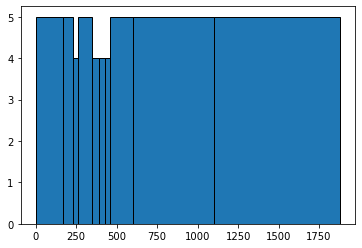

In [111]:
# Create a plot where you set the time interval bins in the bins variable, the plot should be as straight as possible, containing an equal number of death events per time interval

test = yv.loc[yv['donor_vital_status'] == 1]

plt.hist(test['time'], bins=[0,165,230,260,345,390,425,460,600,1100,1880],ec='black')

In [112]:
# Here we set the breaks for our time intervals which we obtained with the plot above

vbreaks = np.array([0,165,230,260,345,390,425,460,600,1100,1880])
n_intervals = len(vbreaks) - 1

In [114]:
# Create the survival array for the ICGC PDAC patients using the nnet_survival fuction 'make_surv_array'
# This function takes the following input:
#    ytime - numpy array of each patient's time until death/censor value
#    ystatus - numpy array of each patient's survival status (1 for death event, 0 for alive/censored)
#    breaks - the breaks for the time intervals that were 

y_v = nnet_survival.make_surv_array(yvtime, yvstatus, vbreaks)

In [115]:
# Create time quantiles to later be used in stratification

first_quantile_v = np.quantile(yvtime,0.25)
second_quantile_v = np.quantile(yvtime,0.5)
third_quantile_v = np.quantile(yvtime,0.75)

255.5
413.5
719.5


In [116]:
# For every patient's time value in yvtime check in what quantile it falls and make a new list that contains the corresponding time quantile for each patient

yvquantile = []
for time in yvtime:
    if time >= 0 and time < first_quantile_v:
        yvquantile.append(1)
    elif time >= first_quantile_v and time < second_quantile_v:
        yvquantile.append(2)
    elif time >= second_quantile_v and time < third_quantile_v:
        yvquantile.append(3)
    elif time >= third_quantile_v:
        yvquantile.append(4)

In [117]:
# For every survival matrix, status value, and quantile value merge the status and quantile values together and merge with the survival matrix.

yv_final = ([],[])

for matrix,status,quantile in zip(y_v,yvstatus,yvquantile):
    yv_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yv_final[1].append(status_quantile)

### Hyperparameter optimization and training of the TCGA PDAC model

In [ ]:
importlib.reload(nnet_survival)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Scale the input features using MinMaxScaler

scaler = MinMaxScaler()
xt = scaler.fit_transform(xt)

# logfile - Filename in which the results will be stored of the hyperparameter tuning.
#           Call this file with Tensorboard to view loss curves and hyperparameter tuning results.
#
# name_of_project - Name of the Keras Tuner project.
#                   Make sure this is different if you want to try a new search, else it will 
#                   just give you the results of the project previous project that had the same name !!!!
#
# name_of_dir - Directory where projects will be stored.

logfile = "Logs/ktuner/logs_tcga_model/"
name_of_project = "tcga_model"
name_of_dir = "tcga_model_dir"

# The Cross validation tuner class, takes as input:
#    hypermodel - A hypermodel class, which is your model but contains hyperparameter values for every parameter you want to test
#    directory - Directory where the hyper parameter tuning project will be stored
#    logger - Takes a TensorBoardLogger value as input which will store the loss of the model during training steps, 
#             which can be used in TensorBoard to create plots
#    oracle - The keras tuner optimization method that you want to use, refer to: https://keras.io/api/keras_tuner/oracles/ for possible oracles.
#             takes as input:
#             objective - The objective of the hyperparameter tuning, and what determines whether a set of parameters is 'good'
#             max_trials - The number of trials you wish to perform, each trial will contain a set of parameters to test.
#
# After creating the class, use .search to initiate the hyperparameter tuning, takes as input:
#    xf_t - the scaled input features to train on
#    yf_final - the label on which predictions will be assessed, contains the survival matrix and status_quantile for a patient
#    epochs - the maximum number of epochs you wish to train (Early stopping is included in the class, so value is determined automatically)
#    verbose - 1 to see progress of hyperparameter tuning in console, 0 to not see progress.
                                                
tuner = CVTuner(
    hypermodel=SurvivalHyperModel(n_intervals),
    project_name=name_of_project,
    directory=name_of_dir,
    logger = TensorBoardLogger(metrics=["val_loss"], logdir=logfile),
    oracle=kt.oracles.BayesianOptimization(
        objective='val_loss',
        max_trials=10))
tuner.search(xt,yt_final,epochs=40000,verbose=1)




### Run TCGA PDAC model just once and store weights (Setting 2)

In [45]:
importlib.reload(nnet_survival)

# Scale the input features using MinMaxScaler
scaler = MinMaxScaler()
xt_t = scaler.fit_transform(xt)

# Set the optimal parameters found for the model
optimal_l2 = 0.00001
optimal_batch = 8

# Create the model with the optimal parameters
model = Sequential()
model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
model.add(nnet_survival.PropHazards(n_intervals))
model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

# Create a tensorboard callback which saves the loss during the training of the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_finetune_model"), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

# Fit the model to the input data xt_t and y_t
history = model.fit(xt_t,y_t,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0) 

# Save the weights of the model
model.save_weights("Weights/finetune_model")  

12668


### Run TCGA PDAC Model with transferred weights from Multi-Cancer Model (Fine-tuning step)

In [63]:
importlib.reload(nnet_survival)

# Scale the input features using MinMaxScaler
scaler = MinMaxScaler()
xt_t = scaler.fit_transform(xt)

# Set the optimal parameters found for the model
optimal_l2 = 0.00001
optimal_batch = 8

# Create a model to initialize the weights of the source model into (should have the same architecture)
init_model = Sequential()
init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
init_model.add(nnet_survival.PropHazards(22))
init_model.compile(loss=nnet_survival.surv_likelihood(22), optimizer=optimizers.Adam(learning_rate=0.00001))

# Load the weights of the source model into the initialization model
init_model.load_weights("Weights/source_model_subset")


# Create a model to run the fine tuning step on (this uses the source model's weights)
model = Sequential()
model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
model.add(nnet_survival.PropHazards(n_intervals))
model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

# Transfer weights of source model's second hidden layer to fine tuning model's second hidden layer
model.layers[1].set_weights(init_model.layers[1].get_weights())


# Create a tensorboard callback which saves the loss during the training of the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_source_finetune_model_subset"), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

# Fit the model to the input data xt_t and y_t
history = model.fit(xt_t,y_t,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0) 

# Save the weights of the model
model.save_weights("Weights/source_finetune_model_subset")  

### Train ICGC PDAC and validate with 5-fold CV

In [ ]:
importlib.reload(nnet_survival)

# Set transfer_learning to True, if you want transfer learning, else set it too False
transfer_learning = True

# File which will store the C-indexes obtained
results_file = "Results/cindexes_fullsetpaad"

cindex_list = []
cindex_train_list = []

total_cindexes = []
total_cindexes_train = []

# Set optimal parameters found with hyperparameter tuning
optimal_l2 = 0.00001
optimal_batch = 8


if transfer_learning == True:
    # Create a model to initialize the weights of the source model into (should have the same architecture)
    
    init_model = Sequential()
    init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
    init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    init_model.add(nnet_survival.PropHazards(22))
    init_model.compile(loss=nnet_survival.surv_likelihood(10), optimizer=optimizers.Adam(learning_rate=0.000001))

    # Load the weights of the source model into the initialization model

    init_model.load_weights("Weights/source_model_full_paad")

# Create Repeated Stratified Kfold cross validation object

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=24)

k = 1

test_performance = []
train_performance = []


# Start the repeated 5 fold cross validation (will repeat 50 times, based on n_splits = 5 and n_repeats = 10)
for train_indices, test_indices in rskf.split(xv,yv_final[1]):
    print("fold: " + str(k) + "/50")
    
    # Create splits of the input data
    # Split the input features of the ICGC PDAC data
    x_train, x_test = xv[train_indices], xv[test_indices]
    # Split the input labels of the ICGC PDAC data (survival matrices)
    y_train, y_test = np.array(yv_final[0])[train_indices], np.array(yv_final[0])[test_indices]
    # Split the status_quantile variables for each patient
    y_train_labels, y_test_labels = np.array(yv_final[1])[train_indices], np.array(yv_final[1])[test_indices]
    # Split the status values for each patient
    ystatus_train, ystatus_test = yvstatus[train_indices], yvstatus[test_indices]
    # Split the time values for each patient
    ytime_train, ytime_test = yvtime[train_indices], yvtime[test_indices]

    # Scale the input train and test features using MinMaxScaler
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Create a model to run on the ICGC PDAC (target) data (this uses the source model's weights)
    model = Sequential()
    model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(n_intervals))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

    
    
    if transfer_learning == True:
        # Transfer weights of source model's second hidden layer to fine tuning model's second hidden layer
        model.layers[1].set_weights(init_model.layers[1].get_weights())


    # Create a tensorboard callback which saves the loss during the training of the model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_fullsetpaad/fold_" + str(k)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    # Fit the model to the input data x_train_scaled and y_train
    history = model.fit(x_train_scaled,y_train,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0)


    # Make predictions on the train data for the training performance
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train_scaled,verbose=0), vbreaks, 365)
    # Calculate C-index for train data using time, predictions and status values
    c_index_train = concordance_index(ytime_train, y_pred, ystatus_train)

    # Make predictions on the test data for test performance
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test_scaled,verbose=0), vbreaks, 365)
    # Calculate C-index for test data using time, predictions and status values
    c_index_test = concordance_index(ytime_test, y_pred, ystatus_test)

    # Store the C-index values in lists to write to .txt files
    train_performance.append(c_index_train)
    test_performance.append(c_index_test)

    total_cindexes.append(c_index_test)
    total_cindexes_train.append(c_index_train)

    # Save results of current fold to file
    with open(results_file, 'a') as o:
        print("Fold: " + str(k) + "\n",file=o)
        print("C-index train set: " + str(c_index_train), file=o)
        print("C-index test set: " + str(c_index_test), file=o)
        o.close()

    k += 1

# Save average C-index values and list of total C-indexes to .txt file
with open(results_file, 'a') as o:
    print("\n",file=o)
    print("Average C-index train total: " + str(sum(total_cindexes_train) / 50),file=o)
    print("Average C-index test total: " + str(sum(total_cindexes) / 50),file=o) 
    print(str(total_cindexes),file=o)
    print(str(total_cindexes_train),file=o)
    o.close()    

### Cox-nnet hyperparameter tuning

In [ ]:
# See: https://garmiregroup.org/cox-nnet/docs/examples/ for an example on how to run Cox-nnet, and documentation

model_params = dict(node_map = None, input_split = None)
search_params = dict(method="adam", learning_rate=0.01, momentum=0.9,
                             max_iter=2000, stop_threshold=0.995, patience=1000, patience_incr=2, rand_seed=123,
                             eval_step=23, lr_decay=0.9, lr_growth=1.0)
cv_params = dict(cv_seed=1, n_folds=5, cv_metric="loglikelihood", L2_range=np.arange(-4.5, 1, 0.5))

likelihoods, L2_reg_params, mean_cvpl = cox_nnet.L2CVProfile(xv,yvtime,yvstatus,
    model_params, search_params, cv_params, verbose=False)

L2_reg = L2_reg_params[np.argmax(mean_cvpl)] #Best L2_reg is -5

with open("Results/Optimal_L2_coxnnet", 'a') as o:
    print("Optimal L2 parameter:\n",file=o)
    print(L2_reg,file=o)

print(L2_reg)

### Comparison Analysis
<p> Compare Transfer learning model to Cox-PH and Cox-nnet model </p>

In [ ]:
results_file = "Results/Model_Comparison"

# Set optimal parameters found with hyperparameter tuning on TCGA PDAC data

optimal_l2 = 0.00001
optimal_batch = 8

# Create a model to initialize the weights of the source model into (should have the same architecture)

init_model = Sequential()
init_model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
init_model.add(nnet_survival.PropHazards(10))
init_model.compile(loss=nnet_survival.surv_likelihood(10), optimizer=optimizers.Adam(learning_rate=0.000001))

# Load the weights of the source model into the initialization model

init_model.load_weights("Weights/source_finetune_model_subset")
 

# Create Repeated Stratified Kfold cross validation object

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=24)

k = 1

train_performance_coxph = []
test_performance_coxph = []

train_performance_coxnnet = []
test_performance_coxnnet = []

train_performance_transfersnnet = []
test_performance_transfersnnet = []

# Start the repeated 5 fold cross validation (will repeat 50 times, based on n_splits = 5 and n_repeats = 10)
for train_indices, test_indices in rskf.split(xv,yv_final[1]):
    print("Loop: " + str(k) + "/50")
    
    # Create splits of the input data
    # Split the input features of the ICGC PDAC data
    x_train, x_test = xv[train_indices], xv[test_indices]
    # Split the input labels of the ICGC PDAC data (survival matrices)
    y_train, y_test = np.array(yv_final[0])[train_indices], np.array(yv_final[0])[test_indices]
    # Split the time values for each patient
    yvtime_train, yvtime_test = yvtime[train_indices], yvtime[test_indices]
    # Split the status values for each patient
    yvstatus_train, yvstatus_test = yvstatus[train_indices], yvstatus[test_indices]
    # Split the custom survival labels used by the cox-ph model
    ysurvival_data_train, ysurvival_data_test = ysurvival_data[train_indices], ysurvival_data[test_indices]

    
    # Scale the input train and test features using MinMaxScaler
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    ### Cox-PH ###
    
    # Create the Cox-PH elastic net model
    cox_elastic = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
    
    # Fit the model on the scaled train data and custom survival data
    cox_elastic.fit(x_train_scaled,ysurvival_data_train)
    
    # Calculate the C-index on the train data
    c_index_train = cox_elastic.score(x_train_scaled,ysurvival_data_train)
    # Calculate the C-index on the test data
    c_index_test = cox_elastic.score(x_test_scaled,ysurvival_data_test)
    
    # Add the C-index train score to train_performance_coxph
    train_performance_coxph.append(c_index_train)
    # Add the C-index test score to test_performance_coxph
    test_performance_coxph.append(c_index_test)
  
    ### Cox-nnet ###

    model_params = dict(node_map = None, input_split = None)
    search_params = dict(method="adam", learning_rate=0.01, momentum=0.9,
                                 max_iter=2000, stop_threshold=0.995, patience=1000, patience_incr=2, rand_seed=123,
                                 eval_step=23, lr_decay=0.9, lr_growth=1.0)
    cv_params = dict(cv_seed=1, n_folds=5, cv_metric="loglikelihood", L2_range=np.arange(-4.5, 1, 0.5))
    
    # Train model the model using the optimal L2 parameter found with the hyperparmaeter tuning
    L2_reg = -4.5
    model_params = dict(node_map = None, input_split = None, L2_reg=np.exp(L2_reg))
    cox_nnet_model, cox_nnet_cost_iter = cox_nnet.trainCoxMlp(x_train_scaled, yvtime_train,yvstatus_train, model_params, search_params, verbose=False)
    
    # Make a prediction on the training data
    cox_nnet_theta_train = cox_nnet_model.predictNewData(x_train_scaled)
    # Make a prediction on the testing data
    cox_nnet_theta_test = cox_nnet_model.predictNewData(x_test_scaled)

    # Calculate train C-index from the time data, predictions made by cox-nnet and the patient status data, store the results in train_performance_coxnnet
    train_performance_coxnnet.append(concordance_index(yvtime_train,-cox_nnet_theta_train,yvstatus_train))
    # Calculate test C-index from the time data, predictions made by cox-nnet and the patient status data, store the results in test_performance_coxnnet
    test_performance_coxnnet.append(concordance_index(yvtime_test,-cox_nnet_theta_test,yvstatus_test))

    ### OUR MODEL ###
    
    # Create a model to run on the ICGC PDAC (target) data (this uses the source model's weights)
    model = Sequential()
    model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(10))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

    
    # Transfer weights of source model's second hidden layer to fine tuning model's second hidden layer
    model.layers[1].set_weights(init_model.layers[1].get_weights())

    # Create a tensorboard callback which saves the loss during the training of the model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_comparison_new/fold_" + str(k)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    # Fit the model to the input data x_train_scaled and y_train
    history = model.fit(x_train_scaled,y_train,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0)

    # Make predictions on the train data for the training performance
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train_scaled,verbose=0), vbreaks, 365)
    # Calculate C-index for train data using time, predictions and status values
    c_index_train = concordance_index(yvtime_train, y_pred, yvstatus_train)
    
    # Make predictions on the test data for test performance
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test_scaled,verbose=0), vbreaks, 365)
    # Calculate C-index for test data using time, predictions and status values
    c_index_test = concordance_index(yvtime_test, y_pred, yvstatus_test)

    # Save the train C-index of our model to train_performance_transfersnnet
    train_performance_transfersnnet.append(c_index_train)
    # Save the test C-index of our model to test_performance_transfersnnet
    test_performance_transfersnnet.append(c_index_test)
    
    # Save the average C-index  and total C-index list each approach every fold
    with open(results_file, 'a') as o:
        print("C-indexes, Cox-PH:\n",file=o)
        print("Train:\n",file=o)
        print("Average C-index: " + str(sum(train_performance_coxph)/k),file=o)
        print(str(train_performance_coxph),file=o)
        print("Test:\n",file=o)
        print("Average C-index: " + str(sum(test_performance_coxph)/k),file=o)
        print(str(test_performance_coxph),file=o)
        print("\n",file=o)
        print("C-indexes, Cox-nnet:\n",file=o)
        print("Train:\n",file=o)
        print("Average C-index: " + str(sum(train_performance_coxnnet)/k),file=o)
        print(str(train_performance_coxnnet),file=o)
        print("Test:\n",file=o)
        print("Average C-index: " + str(sum(test_performance_coxnnet)/k),file=o)
        print(str(test_performance_coxnnet),file=o)
        print("\n",file=o)
        print("C-indexes, our model:\n",file=o)
        print("Train:\n",file=o)
        print("Average C-index: " + str(sum(train_performance_transfersnnet)/k),file=o)
        print(str(train_performance_transfersnnet),file=o)
        print("Test:\n",file=o)
        print("Average C-index: " + str(sum(test_performance_transfersnnet)/k),file=o)
        print(str(test_performance_transfersnnet),file=o)
        print("\n",file=o)
    
    o.close()
    
    k += 1

    
    


### Test survival probabilities for patient 5

In [42]:
test_patient = xv[5]

In [45]:
xv = np.delete(xv, 5, 0)

In [46]:
test_patient_y = yv_final[0][5]

In [47]:
y_train_all = list(yv_final[0])

In [48]:
y_train_all = np.delete(y_train_all, 5, 0)

In [ ]:
# Set the file that stores the survival probabilities

results_file = "Results/Model_surv_probabilities"

# Set optimal parameters found with hyperparameter tuning on TCGA PDAC data
optimal_l2 = 0.00001
optimal_batch = 8

# Create a model to initialize the weights of the source model into (should have the same architecture)

init_model = Sequential()
init_model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
init_model.add(nnet_survival.PropHazards(10))
init_model.compile(loss=nnet_survival.surv_likelihood(10), optimizer=optimizers.Adam(learning_rate=0.000001))

# Load the weights of the source model into the initialization model

init_model.load_weights("Weights/source_finetune_model_subset")
 

# Create Repeated Stratified Kfold cross validation object

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=24)

k = 1

surv_probablity = []

# Set the prediction time you want to get the survival probability of

pred_time = 456.25

# Start the repeated 5 fold cross validation (will repeat 50 times, based on n_splits = 5 and n_repeats = 10)
for _ in range(50):
    print("Loop: " + str(k) + "/50")
    
    # Scale the input train and test features using MinMaxScaler
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(xv)
    x_test_scaled = scaler.transform(test_patient.reshape(1, -1))
    # xv_ext_train.iloc[:,0:14242] = scaler.transform(xv_ext_train.iloc[:,0:14242])
    # xv_ext_test.iloc[:,0:14242] = scaler.transform(xv_ext_test.iloc[:,0:14242])

    # Create a model to run on the ICGC PDAC (target) data (this uses the source model's weights)
    model = Sequential()
    model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(10))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

    
    # Transfer weights of source model's second hidden layer to fine tuning model's second hidden layer
    model.layers[1].set_weights(init_model.layers[1].get_weights())

    # Create a tensorboard callback which saves the loss during the training of the model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_icgc_testpatient/fold_" + str(k)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    # Fit the model to the input data x_train_scaled and y_test_all
    history = model.fit(x_train_scaled,y_train_all,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0)

    # Predict the survival probability of patient 5 at set pred_time
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test_scaled,verbose=0), vbreaks, pred_time)
    
    # Save survival probability to list
    surv_probablity.append(y_pred)
    
    k += 1

# Store survival probabilities to file
with open(results_file, 'a') as o:
    print("Survival probabilities for " + str(pred_time) + " days:\n", file=o)
    print(str(surv_probablity),file=o)
    print(str(sum(surv_probablity)/50),file=o)
    o.close()

    
    
